## CHEME 5660: Using Single Index Models in Markowitz Portfolio Allocations

### Introduction
Fill me in.

### Example setup

In [1]:
import Pkg; Pkg.activate("."); Pkg.resolve(); Pkg.instantiate();

  Activating project at `~/Desktop/julia_work/CHEME-5660-Markets-Mayhem-Example-Notebooks/jupyter-notebooks/example-SIM-markowitz`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Markets-Mayhem-Example-Notebooks/jupyter-notebooks/example-SIM-markowitz/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Markets-Mayhem-Example-Notebooks/jupyter-notebooks/example-SIM-markowitz/Manifest.toml`


In [15]:
# load req packages -
using Convex
using SCS
using DataFrames
using CSV
using Dates
using Colors
using Plots
using Statistics
using MathOptInterface
using FileIO
using JLD2
using PrettyTables
using Distributions
using LinearAlgebra

# setup paths -
const _ROOT = pwd();
const _PATH_TO_DATA = joinpath(_ROOT, "data");

### Load the example code library
The call to the `include` function loads the `Example-Markowitz-CodeLib.jl` library into the notebook; the library contains types and functions we use during the lab:

__Functions__:
* `compute_minvar_portfolio_allocation --> Tuple` and `compute_minvar_portfolio_allocation_risk_free --> Tuple` compute the optimum (minimum) risk given a specified reward for risky and risky+risk-free portfolios. 
* `compute_fractional_return_array --> DataFrame` computes the fractional return for a firm $i$
* `compute_covariance_array --> Array{Float64,2}` computes the covariance matrix $\Sigma$ from the return values.

In [167]:
include("Example-SIM-Markowitz-CodeLib.jl");

In [87]:
# daily risk-free rate -
r̄ = 0.0403;
risk_free_daily = ((1+r̄)^(1/365) - 1);

# how many days of data are we using?
m = 200;

### a) Load the historical data set
The historical data set was downloaded using the [RESTful Application Programming Interface of Polygon.io](https://polygon.io) using the [PQPolygonSDK.jl](https://github.com/Paliquant/PQPolygonSDK.jl) package. The data contains daily Open High Low Close (OHLC) data for N = 100 stocks for the last two-years.

In [7]:
# load the JLD2 portfolio data file -
price_data_dictionary = load(joinpath(_PATH_TO_DATA, "CHEME-5660-Portfolio-10-30-22.jld2"))["dd"];

In [8]:
# we have these ticker symbols in our data set -
ticker_symbol_array = sort(keys(price_data_dictionary) |> collect);

# How many tickers do we have?
Nₐ = length(ticker_symbol_array);

### b) Estimate SIMs for each asset in our collection

#### Phase 1: Estimate $\left(\alpha_{i}, \beta_{i}\right)$ usind direct matrix inversion

In [88]:
# initialize -
sim_model_dictionary = Dict{String, SingleIndexModel}();

# compute the excess nreturn for SPY (which is in the data set)
Rₘ = compute_excess_log_return(price_data_dictionary["SPY"]; rf = risk_free_daily, m = m);

# main loop -
for i ∈ 1:Nₐ
    
    # grab a ticker -
    asset_ticker = ticker_symbol_array[i];
    
    # compute the excess return for asset_ticker -
    Rᵢ = compute_excess_log_return(price_data_dictionary[asset_ticker], rf = risk_free_daily, m = m);
    
    # formulate the Y and X arrays with the price data -
    max_length = length(Rᵢ);
    Y = Rᵢ;
    X = [ones(max_length) Rₘ];
    
    # compute θ -
    θ = inv(transpose(X)*X)*transpose(X)*Y
    
    # package -
    sim_model = SingleIndexModel();
    sim_model.α = θ[1];
    sim_model.β = θ[2];
    sim_model.r = risk_free_daily;
    sim_model_dictionary[asset_ticker] = sim_model;
end

In [166]:
sim_model_dictionary["VXX"]

SingleIndexModel(0.001245594352048381, -1.6958055234732279, 0.00010825005887427075, Normal{Float64}(μ=-2.2551405187698493e-19, σ=0.027596151964019794))

#### Phase 2: Estimate the error models $\epsilon\left(t\right)$

In [90]:
# compute the error model -

# main loop -
for i ∈ 1:Nₐ
    
    # grab a ticker -
    asset_ticker = ticker_symbol_array[i];
    
    # grab the model -
    sim_model = sim_model_dictionary[asset_ticker];
    
    # compute the excess return for asset_ticker (data) -
    Rᵢ = compute_excess_log_return(price_data_dictionary[asset_ticker]; rf = risk_free_daily, m = m);
    
    # what is the length -
    max_length = length(Rᵢ);
    
    # compute the model excess return -
    αᵢ = sim_model.α
    βᵢ = sim_model.β
    R̂ᵢ = αᵢ .+ βᵢ .* Rₘ
    
    # compute the residual -
    Δ = Rᵢ .- R̂ᵢ;
    
    # Esimate a distribution -
    d = fit_mle(Normal, Δ);
    
    # update the sim_model -
    sim_model.ϵ = d;
end

##### Visualize SIM performance

In [179]:
# pick an asset -
asset_ticker = "VXX"
sim_model = sim_model_dictionary[asset_ticker];

# compute the excess return for asset_ticker (data) -
Rᵢ = compute_excess_log_return(price_data_dictionary[asset_ticker]; rf = risk_free_daily, m = m);

# evaluate the SIM (without noise) -
R̂ᵢ = evaluate_model(sim_model, sort(Rₘ));

# sample the SIM to get the uncertainty region -
R̂ᵢ_samples = sample_sim_model(sim_model, sort(Rₘ); 𝒫 = 1000);

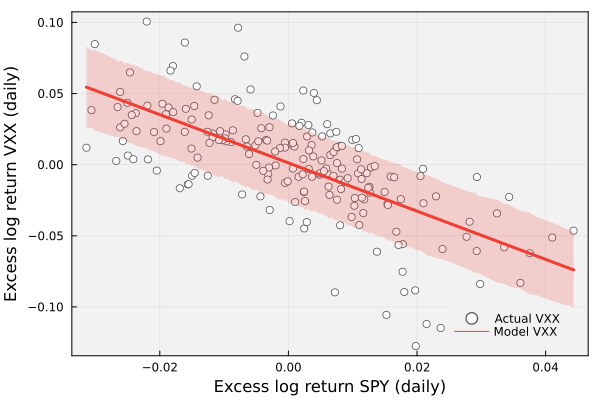

In [180]:
# data and expected value -
scatter(Rₘ, Rᵢ, mc=colorant"#FFFFFF", msc=colorant"#55565A", label="Actual $(asset_ticker)", legend=:bottomright)

# uncertainty region -
L = R̂ᵢ .- std(R̂ᵢ_samples,dims=2)
U = R̂ᵢ .+ std(R̂ᵢ_samples,dims=2)

plot!(sort(Rₘ), R̂ᵢ, fillrange=U, fillalpha = 0.2, lw=2, label="", c=colorant"#EF4035")
plot!(sort(Rₘ), R̂ᵢ, fillrange=L, fillalpha = 0.2, lw=2, label="", c=colorant"#EF4035")

plot!(sort(Rₘ), R̂ᵢ, lw=3, c=colorant"#EF4035", bg=colorant"#F2F2F2", 
    background_color_outside="white", framestyle = :box, fg_legend = :transparent, label="Model $(asset_ticker)")


# labels -
xlabel!("Excess log return SPY (daily)",fontsize=18)
ylabel!("Excess log return $(asset_ticker) (daily)",fontsize=18)

### c) Markowitz Allocation using Single Index Models of Risk and Return